In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import scipy
import scipy.misc
import scipy.cluster

In [2]:
# NOTE: I am not expecting you to know how to write these on your own!
def quantizetopalette(silf, palette, dither=False):
    """Convert an RGB or L mode image to use a given P image's palette."""
    # refs:
    # [1] https://stackoverflow.com/questions/29433243/convert-image-to-specific-palette-using-pil-without-dithering

    silf.load()

    # use palette from reference image
    palette.load()
    if palette.mode != "P":
        raise ValueError("bad mode for palette image")
    if silf.mode != "RGB" and silf.mode != "L":
        raise ValueError(
            "only RGB or L mode images can be quantized to a palette"
            )
    im = silf.im.convert("P", 1 if dither else 0, palette.im)
    # the 0 above means turn OFF dithering

    # Later versions of Pillow (4.x) rename _makeself to _new
    try:
        return silf._new(im)
    except AttributeError:
        return silf._makeself(im)


def convert_image(image, ncolors = 8):
    # refs:
    # [1]: https://stackoverflow.com/questions/3241929/python-find-dominant-most-common-color-in-an-image
    image = image.convert('RGB') # can't use alpha channel
    NUM_CLUSTERS = ncolors # unnecessary re-naming
    
    ar = np.array(image) # to data
    
    shape = ar.shape
    ar = ar.reshape(np.product(shape[:2]), shape[2]).astype(float)

    print('finding ' + str(ncolors) + ' most common colors.  Note, if "ncolors" is large, this can take a while...')
    codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)
    print('Done finding colors! cluster centres in RGB:\n', codes)

    vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
    counts, bins = np.histogram(vecs, len(codes))    # count occurrences
    
    # into a 256 palette, integer types
    reds = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,0])).astype('int')
    greens = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,1])).astype('int')
    blues = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,2])).astype('int')

    # palette formatting:
    myPalette = []
    for i in range(256):
        myPalette.extend( (reds[i],greens[i],blues[i]))
        
    palimage = Image.new('P', (16, 16)) # placeholder image
    palimage.putpalette(myPalette)
    newimage = quantizetopalette(image, palimage, dither=False)
    newimage = newimage.convert('RGB')
    return newimage, codes

# similar to above, but allows you to import your own RGB sequence
def convert_image_specific(image, colors = [ [255, 255, 255], [255, 0, 0], [0,0,255], [0, 0, 0] ]):
    image = image.convert('RGB') # can't use alpha channel
    NUM_CLUSTERS = len(colors) # unnecessary re-naming
    codes = np.array(colors) # unnecessary renaming
    
    # into a 256 palette, integer types
    reds = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,0])).astype('int')
    greens = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,1])).astype('int')
    blues = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,2])).astype('int')

    # palette formatting:
    myPalette = []
    for i in range(256):
        myPalette.extend( (reds[i],greens[i],blues[i]))
        
    palimage = Image.new('P', (16, 16)) # placeholder image
    palimage.putpalette(myPalette)
    newimage = quantizetopalette(image, palimage, dither=False)
    newimage = newimage.convert('RGB')
    return newimage, codes

* **Similarities & Differences:**  
    There are 3 pictures with the same "star", my favorite dog. And according to the bar cahrt, the color of dog's fur takes a small portion among all the colors in an image. This indicates similarities among 3 images, but because of different exposure levels and different backgrounds, the color components are not the same. If I specify certain color combinations for the image, then the distribution of colors would be pretty easy and the image would lose some details.
    
    
* **Shorcomings:**
    1. Before handling the image, we choose to simplify it with several colors, it actually makes the process easier, but how to choose the number of colors is subjective to human eyes, it is not precise enough.
    2. For images with high resolution or size, like 2M, it would take several minutes even longer time to run the convert_image function. 

Given the image file, and the number of colors to simplify, the function below can plot the distribution of each color in an image.

In [3]:
def color_components_plot(im,ncolors):
    new_im, new_rgbs = convert_image(im, ncolors = ncolors)
    new_im_data = np.array(new_im)
    unique_colors = np.unique(new_im_data.reshape(-1,new_im_data.shape[2]),axis=0)

    number_of_pixels_of_a_color = []
    color_labels = []
    color_values = []

    for icolor, rgba in enumerate(unique_colors):
        #1. mask out pixels at one color
        reds_mask = new_im_data[:,:,0] == rgba[0]
        greens_mask = new_im_data[:,:,1] == rgba[1]
        blues_mask = new_im_data[:,:,2] == rgba[2]
        pixel_mask = reds_mask & greens_mask & blues_mask

        #2. count up all pixels
        this_color_pixels = new_im_data[pixel_mask]
        npixels = len(new_im_data[pixel_mask])

        # store
        number_of_pixels_of_a_color.append(npixels)
        # name the colors labels
        color_labels.append('Color #'+str(icolor))
        #color values
        color_values.append(rgba/255)

    fig, ax = plt.subplots(figsize=(8,6))
    myBarChart = ax.bar(color_labels,number_of_pixels_of_a_color)
    for i in range(len(myBarChart)):
        myBarChart[i].set_color(color_values[i])
        myBarChart[i].set_edgecolor('black')
    plt.show()

# Image 1

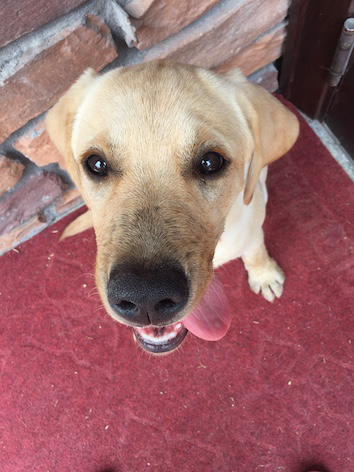

In [4]:
path_to_image1 = '/Users/W/Downloads/IMG_1018.jpg'
im_1 = Image.open(path_to_image1)
im_1

finding 6 most common colors.  Note, if "ncolors" is large, this can take a while...
Done finding colors! cluster centres in RGB:
 [[140.05579044 117.49181985 112.01943934]
 [ 53.76537521  35.40791944  38.67821585]
 [185.17190806 160.30054725 148.38518789]
 [139.03837597  66.78395996  78.54433815]
 [175.36132648  84.94064524 102.66167204]
 [225.39643982 211.34599599 193.4283669 ]]


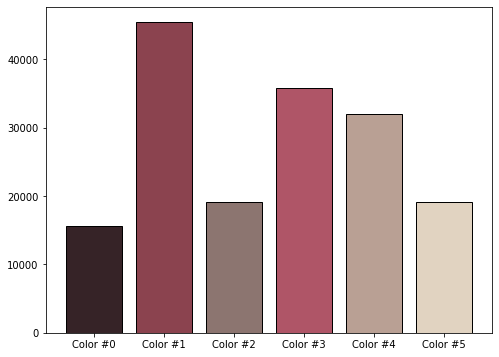

In [5]:
color_components_plot(im_1,6)

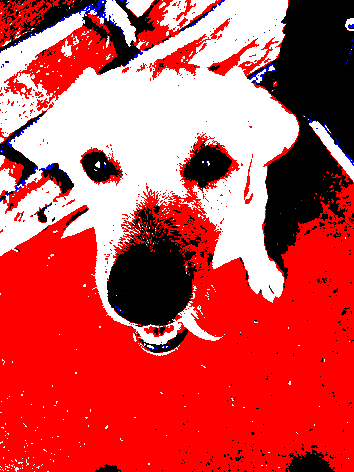

In [6]:
new_im1, new_rgbs1 = convert_image_specific(im_1, colors = [ [255, 255, 255], [255, 0, 0], [0,0,255], [0, 0, 0] ])
new_im1

finding 3 most common colors.  Note, if "ncolors" is large, this can take a while...
Done finding colors! cluster centres in RGB:
 [[255.           0.           0.        ]
 [255.         255.         255.        ]
 [  0.           0.           7.59210727]]


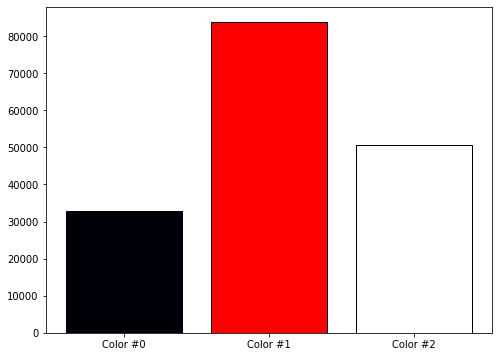

In [7]:
color_components_plot(new_im1,3)

# Image 2

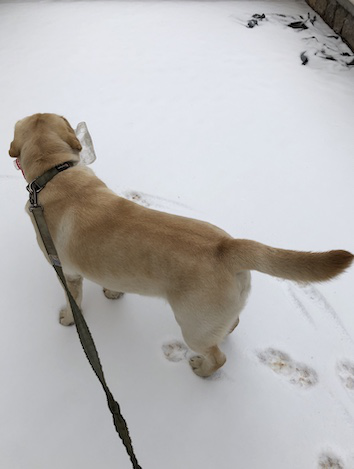

In [8]:
path_to_image2 = '/Users/W/Downloads/IMG_3437.jpg'
im_2 = Image.open(path_to_image2)
im_2

finding 4 most common colors.  Note, if "ncolors" is large, this can take a while...
Done finding colors! cluster centres in RGB:
 [[176.63788514 176.75134209 178.56674336]
 [107.34698179  91.84805058  72.38681319]
 [205.1522271  206.87659617 211.92774072]
 [223.44897681 226.17854707 232.44892565]]


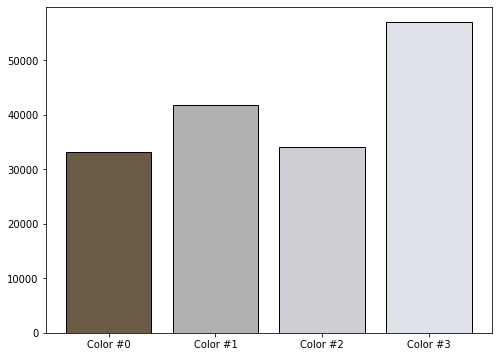

In [9]:
color_components_plot(im_2,4)

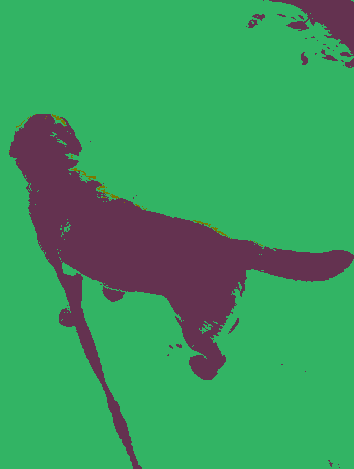

In [10]:
new_im2, new_rgbs2 = convert_image_specific(im_2, colors = [ [125, 120, 0], [50, 180, 100], [100,50,80]])
new_im2

finding 2 most common colors.  Note, if "ncolors" is large, this can take a while...
Done finding colors! cluster centres in RGB:
 [[ 50.         180.         100.        ]
 [100.21036767  50.58902948  79.32682345]]


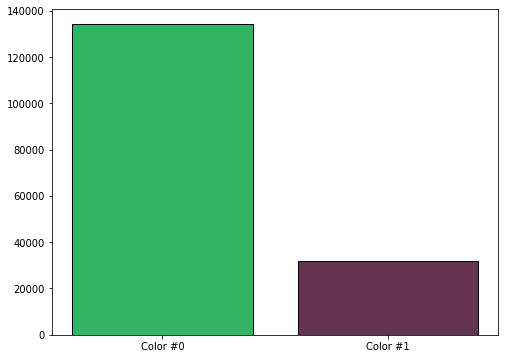

In [11]:
color_components_plot(new_im2,2)

# Image 3

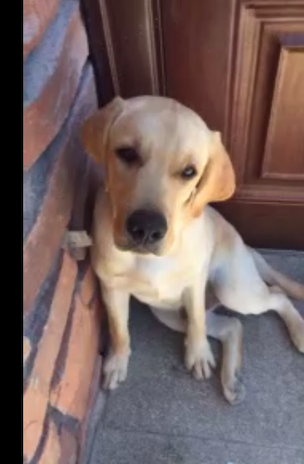

In [12]:
path_to_image3 = '/Users/W/Downloads/DB2.PNG'
im_3 = Image.open(path_to_image3)
im_3

finding 6 most common colors.  Note, if "ncolors" is large, this can take a while...
Done finding colors! cluster centres in RGB:
 [[112.14148978  92.8631224   69.96989685]
 [222.66544624 225.36102766 231.57206784]
 [202.18181145 203.72199201 208.57207341]
 [178.21174405 178.72746567 181.21009328]
 [139.21798389 130.04265864 116.65342066]
 [ 53.06594614  45.84044697  35.32460158]]


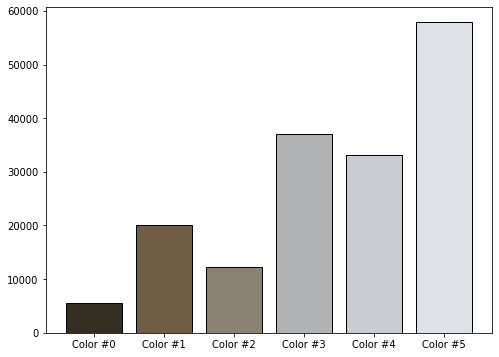

In [13]:
color_components_plot(im_2,6)

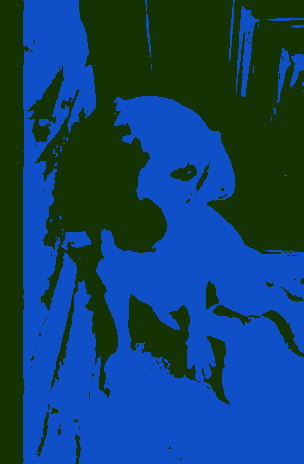

In [14]:
new_im3, new_rgbs3 = convert_image_specific(im_3, colors = [ [0, 0, 130], [15, 80, 200], [20,50,2]])
new_im3